In [1]:
###############################################################################
#                                                                             #
#    This program is free software: you can redistribute it and/or modify     #
#    it under the terms of the GNU General Public License as published by     #
#    the Free Software Foundation, either version 3 of the License, or        #
#    (at your option) any later version.                                      #
#                                                                             #
#    This program is distributed in the hope that it will be useful,          #
#    but WITHOUT ANY WARRANTY; without even the implied warranty of           #
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the            #
#    GNU General Public License for more details.                             #
#                                                                             #
#    You should have received a copy of the GNU General Public License        #
#    along with this program. If not, see <http://www.gnu.org/licenses/>.     #
#                                                                             #
###############################################################################
import matplotlib as mpl

import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import ListedColormap

from sciviso import Vis

# https://stackoverflow.com/questions/55501860/how-to-put-multiple-colormap-patches-in-a-matplotlib-legend
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent],
                          width / self.num_stripes,
                          height,
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)),
                          transform=trans, linewidth=0)
            stripes.append(s)
        return stripes


class Emapplot(Vis):

    def __init__(self, df: pd.DataFrame, size_column='Count', color_column='p.adjust', id_column='ID',
                 label_column='Description', overlap_column='gene_id', overlap_sep='/', title='',
                 config={}):
        super().__init__(df)
        self.title=title
        self.size = size_column
        self.color = color_column
        self.id = id_column
        self.label = label_column
        self.overlap_column = overlap_column
        self.overlap_sep = overlap_sep
        if config:
            self.load_style(config)

    def build_graph(self, min_count, max_count, min_overlap):
        """
        Builds a graph from the dataframe from R
        :return:
        """
        G = nx.Graph()
        node_cmap = 'viridis'
        edge_cmap = 'Greys'

        edge_map = defaultdict(dict)
        gene_ids = self.df[self.overlap_column].values
        gene_ids = [set(genes.split(self.overlap_sep)) for genes in gene_ids] # Turn it into a list
        all_genes = 0
        for g in gene_ids:
            all_genes += len(g)
        #min_overlap = int(0.01*all_genes) if int(0.01*all_genes) < 20 else 20
        print(min_overlap, 'min_overlap')
        # Want to iterate over and get the maps between the two
        overlapping_numbers = []
        for i, id_i in enumerate(self.df[self.id].values):
            for j, id_j in enumerate(self.df[self.id].values):
                if i != j:
                    if edge_map.get(id_j):
                        if edge_map[id_j].get(id_i):
                            continue
                        else:
                            overlapping_genes = len(gene_ids[i] & gene_ids[j])
                            if overlapping_genes >= min_overlap:
                                edge_map[id_i][id_j] = overlapping_genes
                                overlapping_numbers.append(overlapping_genes)
                    else:
                        overlapping_genes = len(gene_ids[i] & gene_ids[j])
                        if overlapping_genes >= min_overlap:
                            edge_map[id_i][id_j] = overlapping_genes
                            overlapping_numbers.append(overlapping_genes)
        edges = []
        for node1 in edge_map:
            for node2 in edge_map[node1]:
                edges.append((node1, node2))

        seen_nodes = []
        edge_groups = defaultdict(list)
        for node_from, node_to_lst in edge_map.items():
            if node_from not in seen_nodes:
                # Now we want to traverse the graph visiting each node
                for node in node_to_lst:
                    if node not in edge_groups[node_from] and node not in seen_nodes:
                        edge_groups[node_from].append(node)
                        seen_nodes.append(node)
                        if edge_map.get(node) and node not in seen_nodes:
                            for node2 in edge_map.get(node):
                                edge_groups[node_from].append(node2)
                                seen_nodes.append(node2)
                seen_nodes.append(node_from)
                edge_groups[node_from].append(node_from)

        G.add_edges_from(edges)
        nodes = G.nodes()
        # Check that all nodes have been added and if not add them
        nodes_to_add = [node_id for node_id in self.df[self.id].values if node_id not in nodes]
        for node in nodes_to_add:
            G.add_node(node)
            edge_groups[node].append(node) # So that we actually draw it!
        # Now we want a list of node sizes and colours
        #mins = np.min(self.df[self.size].values)
        #maxs = np.max(self.df[self.size].values)
        #norms = maxs - mins
        counts =[100*(c/max_count) for c in self.df[self.size].values] # [10 + (100 * (max_count - c)/(max_count - min_count)) for c in self.df[self.size].values]
        self.df["norm_sized"] = [int(100*(c/max_count)) for c in self.df[self.size].values]
        print(self.df[self.size])
        colour = []
        for p in self.df[self.color].values:
            if p < 0.0001:
               colour.append("#065f46")
            elif p < 0.001:
                colour.append("#059669")
            elif p < 0.01:
                colour.append("#34d399")
            elif p < 0.05:
                colour.append("#a7f3d0")
        # Colour the edges by the number of genes shared between the nodes
        edge_values = [edge_map[edge[0]][edge[1]] for edge in edges]


        lut = dict(zip(set(edge_values), sns.dark_palette("#d1d5db", len(set(edge_values)), reverse=True)))
        edge_cmap = ListedColormap(sns.dark_palette("#d1d5db", len(set(edge_values)), reverse=True))
        edge_colours = [] #pd.DataFrame(edge_values)[0].map(lut).values
        edge_alphas = []
        for c in edge_values:
            if c < 10:
                edge_colours.append("#bfbfbf")
            elif c < 20:
                edge_colours.append("#a6a6a6")
            elif c < 30:
                edge_colours.append("#808080")
            elif c < 40:
                edge_colours.append("#595959")
            elif c < 50:
                edge_colours.append("#333333")
            else:
                edge_colours.append("#0d0d0d")
            edge_colours.append(lut[c])
        # Need to create a layout when doing
        # separate calls to draw nodes and edges
        pos = nx.spring_layout(G,  k=1) #nx.kamada_kawai_layout(G) # nx.spring_layout(G,  k=2) #
        nx.draw_networkx_nodes(G, pos, node_color=colour, node_size=self.df["norm_sized"].values) #self.df[self.size].values)

        labels = dict(zip(self.df[self.id].values, self.df[self.label].values))
        nx.draw_networkx_edges(G, pos, edgelist=edges, alpha=0.8, edge_color=edge_colours, width=0.5, arrows=False) #, edge_color=edge_colours, arrows=False)
        # Plot the small labels and then for each "cluster" plot the smallest GO ID this should
        # correspond to the "top" term.
        # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.clique.find_cliques.html#networkx.algorithms.clique.find_cliques
        cliques = nx.find_cliques(G)
        labels_to_draw = {}
        gene_numbers = dict(zip(self.df[self.id].values, self.df[self.size].values))

        # If the user has selected the smallest GO term as the one they want
        # for clique in cliques:
        #      # For each clique we want to get the GO term with the smallest ID
        #      smallest_GO = min([g.split(':')[1] for g in clique])
        #      labels_to_draw[f'GO:{smallest_GO}'] = labels[f'GO:{smallest_GO}']

        #for node, node_group in edge_groups.items():
            # For each clique we want to get the GO term with the smallest ID
            #smallest_GO = np.argmax([gene_numbers.get(g) for g in node_group])
            #go = node_group[smallest_GO]
            #labels_to_draw[go] = labels[go]

        small_labels = {}
        for go in labels:
            if not labels_to_draw.get(go):
                small_labels[go] = labels[go]
        nx.draw_networkx_labels(G, pos, small_labels, font_size=self.axis_font_size, font_color='black',
                                font_family='sans-serif', verticalalignment='bottom', clip_on=False)

        # nx.draw_networkx_labels(G, pos, labels_to_draw, font_size=self.label_font_size, verticalalignment='bottom',
        #                         font_family='sans-serif', clip_on=False)
        # cmin_node = '{:.2e}'.format(min(colour))
        # cmax_node = '{:.2e}'.format(max(colour))

        # cmap_labels = [f'G.shared:{min(overlapping_numbers)}-{max(overlapping_numbers)}']
        # # create proxy artists as handles:
        # cmaps = [edge_cmap] #plt.get_cmap(node_cmap), edge_cmap]
        # cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
        # handler_map = dict(zip(cmap_handles,
        #                        [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
        # legend2 = plt.legend(handles=cmap_handles,
        #            labels=cmap_labels,
        #            handler_map=handler_map,
        #            fontsize=8, loc='upper right')
        #
        # plt.gca().add_artist(legend2)
        #
        # gene_min = int(min_count) #int(np.min(self.df[self.size].values))
        # gene_mean = int(((max_count-min_count)/2)) #int(np.mean(self.df[self.size].values))
        # gene_max = int(max_count) #int(np.max(self.df[self.size].values))
        # # gmin = plt.scatter([], [], s=int(100*(gene_min/max_count)), marker='o', color='#222')
        # # gmid = plt.scatter([], [], s=int(100*(gene_mean/max_count)), marker='o', color='#222')
        # # gmax = plt.scatter([], [], s=int(100*(gene_max/max_count)), marker='o', color='#222')
        # gmin = plt.scatter([], [], s=int(100*(min_count/max_count)), marker='o', color='#222')
        # gmid = plt.scatter([], [], s=int(100*(gene_mean/max_count)), marker='o', color='#222')
        # gmax = plt.scatter([], [], s=int(100*(1)), marker='o', color='#222')
        # legend = plt.legend((gmin, gmid, gmax),
        #            (str(gene_min), str(gene_mean), str(gene_max)),
        #            scatterpoints=1,
        #            loc='lower left',
        #            ncol=1,
        #            fontsize=8, bbox_to_anchor=(0, -0.1))
        # legend.set_title("No. Genes")

        #plt.gca().add_artist(legend)
        plt.axis("off")

In [2]:
import os
import pandas as pd
import seaborn as sns
from sciviso import Scatterplot
from scircm import SciRCM
from scivae import Vis
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import defaultdict
from sciutil import SciUtil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud

ClusterGoSummary_MDS_TMDE_VAE.csv
4 min_overlap
0     5
1     6
2     5
3     5
6     5
8     9
10    9
12    9
13    5
17    9
18    5
19    5
Name: Count, dtype: int64


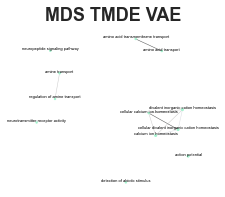

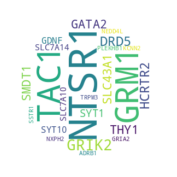

ClusterGoSummary_TMDE_VAE.csv
ClusterGoSummary_TPDS_TMDE_VAE.csv
ClusterGoSummary_TMDS_VAE.csv
4 min_overlap
0      21
1      19
2      13
3      12
4      13
       ..
90      6
103    11
104     7
110     6
112     6
Name: Count, Length: 62, dtype: int64


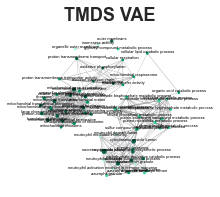

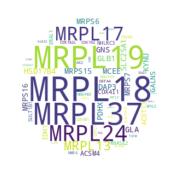

ClusterGoSummary_TPDS_VAE.csv
4 min_overlap
0     8
1     3
2     7
3     6
6     4
7     5
8     5
9     4
10    4
11    4
13    8
14    8
15    6
16    6
17    6
19    4
20    7
21    7
22    6
23    3
24    8
25    3
26    6
27    6
29    3
30    3
32    3
33    3
34    4
35    3
Name: Count, dtype: int64


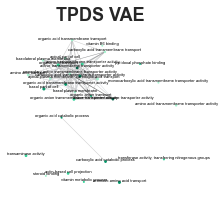

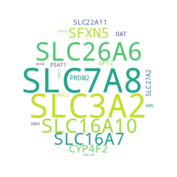

ClusterGoSummary_MDS_VAE.csv
4 min_overlap
0     2
1     2
2     2
3     2
4     1
5     1
6     1
7     2
8     1
9     2
10    1
11    1
12    3
13    2
Name: Count, dtype: int64


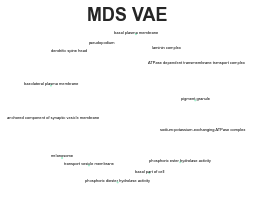

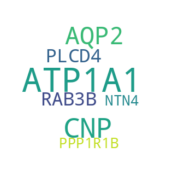

ClusterGoSummary_TPDE_TMDS_VAE.csv
4 min_overlap
0      18
1      22
2      20
4      16
5      12
6      10
9      10
10     10
12     10
13     11
14      9
16     12
19     10
21     13
27      9
31     11
34      9
44     11
51     10
52      9
55     10
60      9
68      9
74      9
87     10
90     11
93      9
94     10
95     12
96     10
97      9
98     15
99     11
100     9
101    13
103    13
111    11
112    11
Name: Count, dtype: int64


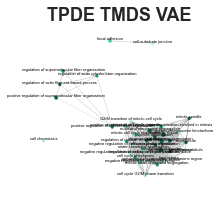

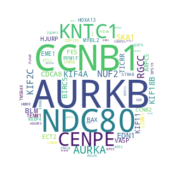

ClusterGoSummary_TPDE_VAE.csv
4 min_overlap
0     6
1     6
2     6
3     2
4     4
5     2
6     2
7     3
8     3
9     3
10    3
11    4
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    3
20    2
21    2
22    2
23    2
24    3
25    3
26    3
27    4
28    3
29    3
30    2
31    2
32    3
33    2
34    4
35    2
36    2
Name: Count, dtype: int64


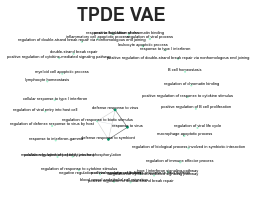

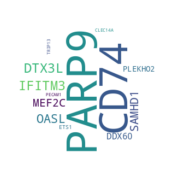

ClusterGoSummary_MDE_TMDS_VAE.csv
4 min_overlap
0      25
1      16
2      18
3      23
4      14
       ..
411    13
414    14
418    13
420    15
421    13
Name: Count, Length: 83, dtype: int64


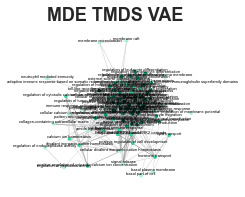

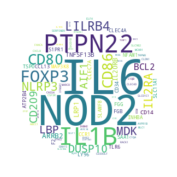

ClusterGoSummary_MDE_VAE.csv


In [8]:
base_dir = '../data/S050_CCRCC_Clark_Cell2019/'
fig_dir = '../figures/sircle/all_patients/all_cpgs/'
output_dir = f'{base_dir}sircle/all_patients/all_cpgs/'
data_dir = f'{base_dir}sircle/all_patients/'
supp_dir =  f'{base_dir}supps/'
test_title = 'all_patients'
rna_test_title = 'all_patients'

files = os.listdir(fig_dir) #ClusterGoSummary_MDE_TMDS_matched-island.csv
cluster_files = [c for c in files if 'ClusterGoSummary' in c]

for c in cluster_files:
    if '.svg' not in c and 'VAE'in c:
        print(c)
        title = c.replace('ClusterGoSummary_', '').replace('.csv', '').replace('_', ' ')
        df = pd.read_csv(f'{fig_dir}{c}')
        # Convert gene ratio to a number
        gr = df['GeneRatio'].values
        gene_ratios = []
        for g in gr:
            g = g.split('/')
            g0 = float(g[0])
            g1 = float(g[1])
            gene_ratios.append(g0/g1)
        df['GeneRatio']  = gene_ratios
        df = df[df['GeneRatio'] > 0.05]
        df = df[df['p.adjust'] < 0.05]
        if len(df) > 1:
            label_font_size =  9
            axis_font_size = 4
            figsize = (3, 3)
            eplot = Emapplot(df, size_column='Count', color_column='p.adjust', id_column='ID',
                             label_column='Description', overlap_column='geneID', overlap_sep='/', title=title,
                             config={'figsize': figsize, 'label_font_size': label_font_size, 'axis_font_size': axis_font_size})
            eplot.build_graph(min_count=20, max_count=200, min_overlap=4)
            plt.title(title, fontsize=18, fontweight='bold')
            plt.gca().set_clip_on=False
            plt.savefig(f'{fig_dir}{c[:-4].replace("ClusterGoSummary_", "")}_NewORA_3x3_VAE.svg', bbox_inches = 'tight', transparent=True)
            plt.show()

            x, y = np.ogrid[:300, :300]
            plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
            plt.rcParams['figure.figsize'] = (3,3)
            font_family = 'sans-serif'
            font = 'Arial'
            mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
            mask = 255 * mask.astype(int)
            wordfeqs = defaultdict(int)
            for g in df['geneID'].values:
                for w in g.split('/'):
                    w = w.replace(' ', '.')
                    wordfeqs[w] += 1
            total_words = len(wordfeqs)
            for w in wordfeqs:
                wordfeqs[w] = wordfeqs[w]/total_words
            # Compute the frequency of each word (since there are duplicates sometimes...)
            wordcloud = WordCloud(background_color="white", mask=mask, repeat=False).generate_from_frequencies(wordfeqs)
            wordcloud_svg = wordcloud.to_svg(embed_font=True)
            f = open(f'{fig_dir}{c[:-4].replace("ClusterGoSummary_", "")}_WordCloud.svg',"w+")
            f.write(wordcloud_svg )
            f.close()
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.show()

In [6]:
files

['EncodedRCM_TPDS_TMDE_all_patients_ccRCC_P0.5-R1.0-M0.1_humanReadable.csv',
 'SIRCLE_A-RNA-protein_TF.csv',
 'EncodedRCM_TPDE_all_patients_ccRCC_P0.5-R1.0-M0.1_humanReadable.csv',
 'TvN_model_optimiser_VAE_MDE_TMDS_all_patients_ccRCC_P0.5-R1.0-M0.1_ccRCC_07032022.json',
 'EncodedRCM_Lysine Metabolism_S_humanReadable.csv',
 'EncodedRCM_Chondroitin and Heparan sulfate biosynthesis_S_humanReadable.csv',
 'EncodedRCM_Sphingolipid Metabolism_humanReadable.csv',
 'EncodedRCM_MDS_all_patients_ccRCC_P0.5-R1.0-M0.1_humanReadable.csv',
 '~$EncodedRCM_MDS_all_patients_ccRCC_P0.5-R1.0-M0.1_humanReadable.xlsx',
 'EncodedRCM_TPDE_TMDS_all_patients_ccRCC_P0.5-R1.0-M0.1_humanReadable.csv',
 'Stages_RNA_Tumor_Repressed.txt',
 'EncodedRCM_GO_LEUKOCYTE_MEDIATED_IMMUNITY_TPDE_S_humanReadable.csv',
 'EncodedRCM_MDS_all_patients_ccRCC_P0.5-R1.0-M0.1_humanReadable.xlsx',
 'EncodedRCM_Keratan sulfate degradation_humanReadable.csv',
 '.DS_Store',
 'EncodedRCM_Keratan sulfate degradation_S_humanReadable.csv',
